# 🧪 Практическая работа: Обобщающая способность модели (Food-101 mini)

В этой работе мы разберём, как модель учится обобщать на новых данных,  
и шаг за шагом проведём серию экспериментов на мини-версии датасета **Food-101**.

---

## 🔹 Данные
- Используем датасет **Food-101** (15 классов, уменьшенная выборка).

---

## 🔹 Модель
- Берём **предобученную ResNet-18** из `torchvision`. 

---

## 🔹 Эксперименты
1. **Бейзлайн** — без аугментаций.  
2. **Слабые аугментации** — crop, flip, цветовые искажения.  
3. **Сильные аугментации + регуляризация** — RandAugment, MixUp, Dropout, Label Smoothing.  
4. Сравниваем результаты всех моделей по метрикам и визуализациям.  

---

In [1]:
# ============================================================
# Подготовка окружения: импорты, устройство, конфиг.
# Этот блок ничего не скачивает и не обучает — только настраивает.
# ============================================================
# --- стандартные библиотеки ---
import os, math, random, time
from dataclasses import dataclass
from typing import List, Tuple, Dict
import pandas as pd # для таблиц
import matplotlib.pyplot as plt  # для графиков
import numpy as np

# --- PyTorch ядро ---
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

# Hugging Face Datasets: для загрузки готовых датасетов (изображения, тексты и др.)
from datasets import load_dataset

# TorchVision: стандартные преобразования изображений (resize, crop, normalize и т.д.)
import torchvision.transforms as T
from torchvision.transforms import InterpolationMode

# -----------------------------
# Функция для воспроизводимости
# -----------------------------
# ========== ВОСПРОИЗВОДИМОСТЬ ==========
def set_seed(seed: int = 42) -> None:
    """Фиксирует ГСЧ для повторяемых результатов (Python/NumPy/PyTorch)."""
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)


set_seed(42)

# -----------------------------
# Определение устройства (CPU/GPU)
# -----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

if torch.cuda.is_available():
    # Детерминизм на CUDA (чуть медленнее, но стабильнее)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # При необходимости:
    # torch.use_deterministic_algorithms(True)  


Device: cuda


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00008.parquet:   0%|          | 0.00/490M [00:00<?, ?B/s]

data/train-00001-of-00008.parquet:   0%|          | 0.00/464M [00:00<?, ?B/s]

data/train-00002-of-00008.parquet:   0%|          | 0.00/472M [00:00<?, ?B/s]

data/train-00003-of-00008.parquet:   0%|          | 0.00/464M [00:00<?, ?B/s]

data/train-00004-of-00008.parquet:   0%|          | 0.00/475M [00:00<?, ?B/s]

data/train-00005-of-00008.parquet:   0%|          | 0.00/470M [00:00<?, ?B/s]

data/train-00006-of-00008.parquet:   0%|          | 0.00/478M [00:00<?, ?B/s]

data/train-00007-of-00008.parquet:   0%|          | 0.00/486M [00:00<?, ?B/s]

data/validation-00000-of-00003.parquet:   0%|          | 0.00/423M [00:00<?, ?B/s]

data/validation-00001-of-00003.parquet:   0%|          | 0.00/413M [00:00<?, ?B/s]

data/validation-00002-of-00003.parquet:   0%|          | 0.00/426M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/75750 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/25250 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 75750
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 25250
    })
})
Классов: 101
Первые 10 классов: ['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito']
Train size: 75,750 | Test size (официальный): 25,250


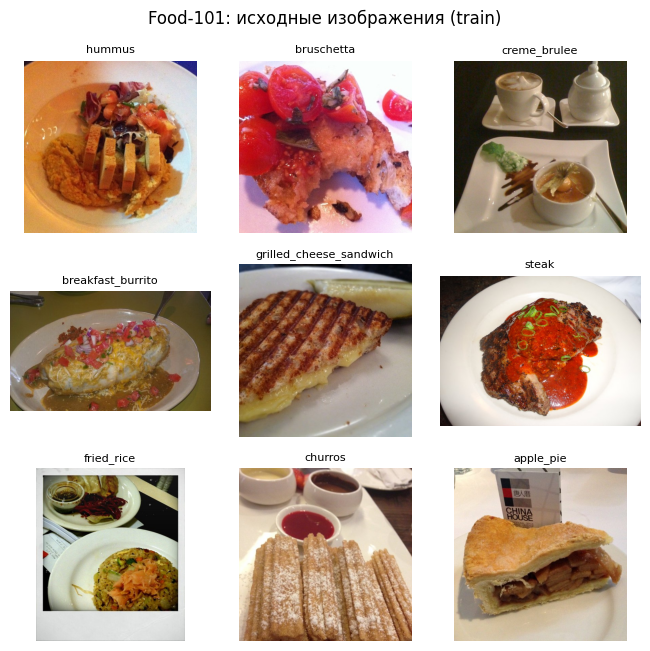

In [2]:
# ===== загрузка Food-101 + check =====
from collections import Counter
from datasets import DatasetDict

DATA_CACHE_DIR = "./data_cache"  # можно поменять на свой путь
ds = load_dataset("ethz/food101", cache_dir=DATA_CACHE_DIR)
print(ds)  # какие сплиты и сколько объектов

# В HF: 'validation' = официальный тест Food-101
train_hf = ds["train"]
test_hf  = ds["validation"]

# Список классов и их число
class_names = train_hf.features["label"].names
num_classes = len(class_names)
print(f"Классов: {num_classes}")
print("Первые 10 классов:", class_names[:10])

# Быстрые суммарные размеры (без тяжелых проходов)
print(f"Train size: {len(train_hf):,} | Test size (официальный): {len(test_hf):,}")

# --- универсальная функция для вывода изображений ---
def show_images(split, idxs=None, rows=3, cols=3, seed=42, title="Примеры изображений"):
    set_seed(seed)
    if idxs is None:
        idxs = random.sample(range(len(split)), k=min(rows * cols, len(split)))
    fig, axs = plt.subplots(rows, cols, figsize=(cols * 2.2, rows * 2.2))
    fig.suptitle(title, y=0.98, fontsize=12)
    for ax, i in zip(axs.ravel(), idxs):
        ex = split[int(i)]
        img, label = ex["image"], class_names[int(ex["label"])]
        ax.imshow(img)
        ax.set_title(label, fontsize=8)
        ax.axis("off")
    for ax in axs.ravel()[len(idxs):]:
        ax.axis("off")
    plt.tight_layout()
    plt.show()

# фиксируем 9 случайных индексов, чтобы потом использовать те же
show_images(train_hf, title="Food-101: исходные изображения (train)")

Выбрали 15 классов:
 ['baby_back_ribs', 'breakfast_burrito', 'bruschetta', 'ceviche', 'deviled_eggs', 'dumplings', 'french_toast', 'fried_rice', 'hot_dog', 'macarons', 'nachos', 'panna_cotta', 'poutine', 'prime_rib', 'waffles']
TRAIN (MINI-15) (N=9000)


,class_id,class,count
0,1,baby_back_ribs,600
1,9,breakfast_burrito,600
2,10,bruschetta,600
3,15,ceviche,600
4,30,deviled_eggs,600
5,32,dumplings,600
6,42,french_toast,600
7,44,fried_rice,600
8,55,hot_dog,600
9,63,macarons,600


VAL   (MINI-15) (N=2250)


,class_id,class,count
0,1,baby_back_ribs,150
1,9,breakfast_burrito,150
2,10,bruschetta,150
3,15,ceviche,150
4,30,deviled_eggs,150
5,32,dumplings,150
6,42,french_toast,150
7,44,fried_rice,150
8,55,hot_dog,150
9,63,macarons,150


TEST  (MINI-15) (N=3750)


,class_id,class,count
0,1,baby_back_ribs,250
1,9,breakfast_burrito,250
2,10,bruschetta,250
3,15,ceviche,250
4,30,deviled_eggs,250
5,32,dumplings,250
6,42,french_toast,250
7,44,fried_rice,250
8,55,hot_dog,250
9,63,macarons,250


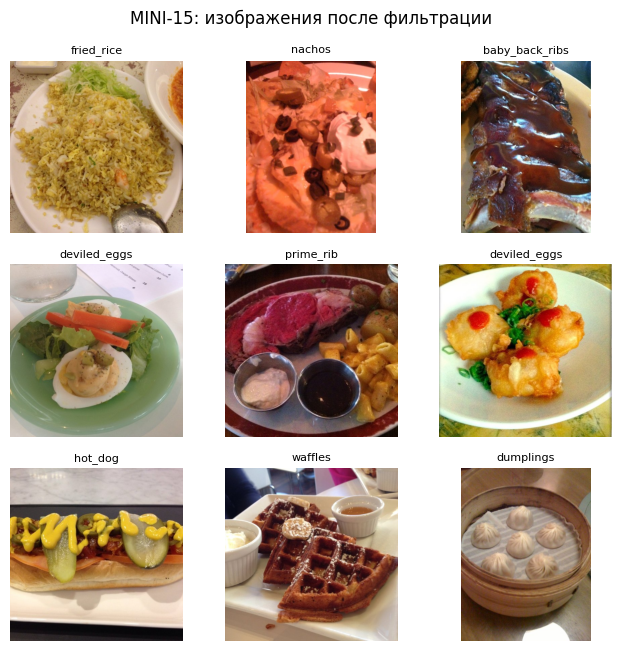

In [3]:
# =============== MINI-15 (train=600, val=150, test=250 на класс) ===============
set_seed(42)  # воспроизводимость выборки

from collections import defaultdict, Counter
from datasets import DatasetDict

K_CLASSES = 15
TRAIN_PER_CLASS = 600
VAL_PER_CLASS   = 150
TEST_PER_CLASS  = 250

# 1) выбираем K классов
all_cls_ids = np.arange(len(class_names))
random.shuffle(all_cls_ids)
chosen_cls = np.sort(all_cls_ids[:K_CLASSES])
chosen_names = [class_names[i] for i in chosen_cls]
print(f"Выбрали {K_CLASSES} классов:\n", chosen_names)

# 2) собираем индексы по классам
by_lbl_train = defaultdict(list)
for i, y in enumerate(train_hf["label"]):
    if y in chosen_cls:
        by_lbl_train[int(y)].append(i)

by_lbl_test = defaultdict(list)
for i, y in enumerate(test_hf["label"]):
    if y in chosen_cls:
        by_lbl_test[int(y)].append(i)

# 3) формируем train/val/test
train_idx_total, val_idx_total, test_idx_total = [], [], []
for c in chosen_cls:
    tr_ids = by_lbl_train[int(c)]
    random.shuffle(tr_ids)
    need_val   = min(VAL_PER_CLASS, len(tr_ids))
    need_train = min(TRAIN_PER_CLASS, max(0, len(tr_ids) - need_val))

    val_idx_c   = tr_ids[:need_val]
    train_idx_c = tr_ids[need_val:need_val + need_train]

    te_ids = by_lbl_test[int(c)]
    random.shuffle(te_ids)
    test_idx_c = te_ids[:min(TEST_PER_CLASS, len(te_ids))]

    val_idx_total.extend(val_idx_c)
    train_idx_total.extend(train_idx_c)
    test_idx_total.extend(test_idx_c)

# 4) собираем HF-сплиты
train_small = train_hf.select(train_idx_total)
val_small   = train_hf.select(val_idx_total)
test_small  = test_hf.select(test_idx_total)

food101_small = DatasetDict({
    "train": train_small,
    "val":   val_small,
    "test":  test_small
})

# 5) быстрая сводка
def balance_table(split, title):
    cnt = Counter(split["label"])
    df = pd.DataFrame({
        "class_id": chosen_cls,
        "class": [class_names[i] for i in chosen_cls],
        "count": [cnt.get(int(c), 0) for c in chosen_cls],
    }).sort_values("class").reset_index(drop=True)
    print(f"{title} (N={len(split)})"); display(df)
    return df

bt_train = balance_table(food101_small["train"], "TRAIN (MINI-15)")
bt_val   = balance_table(food101_small["val"],   "VAL   (MINI-15)")
bt_test  = balance_table(food101_small["test"],  "TEST  (MINI-15)")

# 6) визуальная проверка
SAMPLE_IDX = random.sample(range(len(food101_small["train"])), 9)
show_images(food101_small["train"], SAMPLE_IDX, title="MINI-15: изображения после фильтрации")

In [4]:
# =============== Ремаппер меток под MINI-15 ===============
set_seed(42)

# строим отображение: старый id -> новый [0..NUM_CLASSES-1]
LABEL2NEW = {int(old): i for i, old in enumerate(chosen_cls)}
NEW2LABEL = {v: k for k, v in LABEL2NEW.items()}

NUM_CLASSES = len(chosen_cls)
print("NUM_CLASSES =", NUM_CLASSES)
print("Пример маппинга:", list(LABEL2NEW.items())[:5])

NUM_CLASSES = 15
Пример маппинга: [(1, 0), (9, 1), (10, 2), (15, 3), (30, 4)]


✅ DataLoader'ы готовы: train=9000, val=2250, test=3750, batch=64
Формы батча: torch.Size([64, 3, 224, 224]) torch.Size([64])


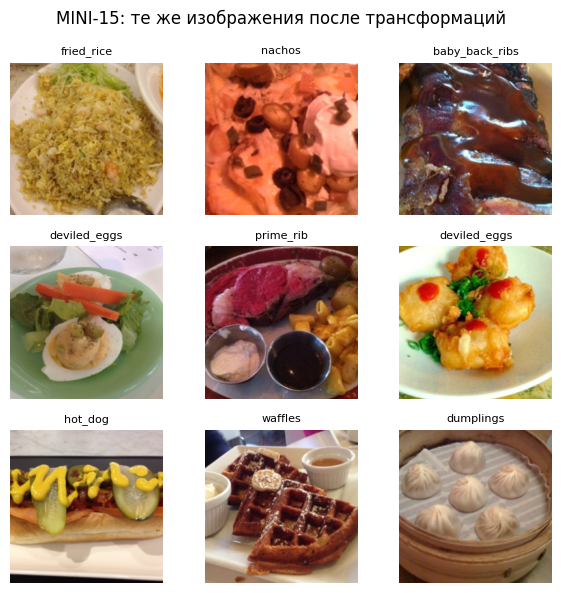

In [6]:
# ===============  трансформации (без аугм) + DataLoader’ы ===============
set_seed(42)

# --- базовые параметры трансформаций ---
IMG_SIZE = 224
MEAN = (0.485, 0.456, 0.406)
STD  = (0.229, 0.224, 0.225)

# --- трансформации (бейзлайн, без аугментаций) ---
baseline_tf = T.Compose([
    T.Resize(256, interpolation=InterpolationMode.BILINEAR),
    T.CenterCrop(IMG_SIZE),
    T.ToTensor(),
    T.Normalize(MEAN, STD),
])

# --- простая обёртка под HF split ---
class HFDataset(torch.utils.data.Dataset):
    def __init__(self, hf_split, transform, label_map):
        self.data = hf_split
        self.tf = transform
        self.label_map = label_map
    def __len__(self): return len(self.data)
    def __getitem__(self, idx):
        ex = self.data[int(idx)]
        x = self.tf(ex["image"])
        y_old = int(ex["label"])
        y = self.label_map[y_old] 
        return x, y

train_ds = HFDataset(food101_small["train"], baseline_tf, LABEL2NEW)
val_ds   = HFDataset(food101_small["val"],   baseline_tf, LABEL2NEW)
test_ds  = HFDataset(food101_small["test"],  baseline_tf, LABEL2NEW)

# --- DataLoader'ы ---
BATCH_SIZE = 64
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=0)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print(f"✅ DataLoader'ы готовы: train={len(train_ds)}, val={len(val_ds)}, test={len(test_ds)}, batch={BATCH_SIZE}")

# --- проверка одного батча ---
xb, yb = next(iter(train_loader))
print('Формы батча:', xb.shape, yb.shape)

# --- визуализация именно тех же картинок, что и в Блоке 2 ---
mean = torch.tensor(MEAN)[:, None, None]
std  = torch.tensor(STD)[:, None, None]
fig, axs = plt.subplots(3, 3, figsize=(6,6))
fig.suptitle("MINI-15: те же изображения после трансформаций", y=0.98, fontsize=12)

for ax, idx in zip(axs.ravel(), SAMPLE_IDX):
    ex = food101_small["train"][idx]
    img_after = baseline_tf(ex["image"])
    img_show = (img_after * std + mean).permute(1,2,0).numpy().clip(0,1)
    ax.imshow(img_show)
    ax.set_title(class_names[int(ex["label"])], fontsize=8)
    ax.axis("off")

plt.tight_layout(); plt.show()


### Препроцессинг под ResNet и DataLoader’ы

Дальше в качестве базовой модели мы будем использовать **ResNet-18**, предобученный на датасете **ImageNet**.  
Это классическая архитектура, которая служит «стандартом де-факто» для визуальных экспериментов:  
она лёгкая, стабильная, и хорошо показывает общие принципы обобщения модели.

#### 🔹 Почему важно подать данные в том же формате, что и у ImageNet

Предобученные модели в `torchvision` (ResNet, VGG, EfficientNet и др.) обучались на **ImageNet-1k**,  
и ожидают входные изображения в строго определённом формате:

| Параметр | Значение | Назначение |
|-----------|-----------|------------|
| Размер входа | **224×224 px** | фиксированный вход для свёрточной архитектуры |
| Диапазон пикселей | `[0, 1]` после `ToTensor()` | нормализованный масштаб значений |
| Средние значения каналов | **mean = (0.485, 0.456, 0.406)** | средние значения RGB по всему ImageNet |
| Стандартные отклонения | **std = (0.229, 0.224, 0.225)** | разброс значений RGB по всему ImageNet |

Модель была обучена на данных, предварительно стандартизованных по этим статистикам,  
поэтому при инференсе и дообучении нужно использовать **точно такие же** значения.  
Если этого не сделать — распределение входных признаков изменится, и веса, рассчитанные на центрированные данные,  
начнут давать смещения: метрики резко ухудшаются.

#### 🔹 Наш препроцессинг под ResNet

Мы используем базовый пайплайн:
Resize(256) → CenterCrop(224) → ToTensor() → Normalize(mean, std)

- **Resize + CenterCrop** — подгоняет размер и обрезает центр кадра,  
  как делалось при обучении ResNet на ImageNet.  
- **ToTensor** — переводит из PIL-изображения в формат PyTorch `[C, H, W]`, диапазон `[0, 1]`.  
- **Normalize** — приводит данные к тем же статистикам (mean/std), что использовались при предобучении.
  

In [7]:
# =============== Инициализация модели ResNet-18 (бейзлайн) ===============
set_seed(42)

from torchvision import models

NUM_CLASSES = 15  # наша mini-версия Food-101
USE_PRETRAINED = True

# 1) Загружаем предобученный ResNet-18
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1 if USE_PRETRAINED else None)

# 2) Замораживаем backbone (все сверточные блоки)
for name, param in model.named_parameters():
    param.requires_grad = False

# 3) Заменяем "голову" (fc) под нашу задачу
in_features = model.fc.in_features
model.fc = nn.Linear(in_features, NUM_CLASSES)

# 4) Переносим на GPU
model = model.to(device)

# 5) Короткий отчёт
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"✅ ResNet-18 загружен: всего параметров = {total_params/1e6:.2f}M, "
      f"обучаемых = {trainable_params/1e6:.2f}M")

# 6) Проверяем, что голова действительно новая
print(model.fc)

# 7) Тестовый прогон одного батча
xb, yb = next(iter(train_loader))
xb = xb.to(device)
with torch.no_grad():
    out = model(xb)
print("Выход модели:", out.shape)  # [batch, NUM_CLASSES]


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 215MB/s]


✅ ResNet-18 загружен: всего параметров = 11.18M, обучаемых = 0.01M
Linear(in_features=512, out_features=15, bias=True)
Выход модели: torch.Size([64, 15])


### Заморозка слоев и что такое Transfer Learning

Мы используем **ResNet-18**, уже обученный на большом датасете **ImageNet**  
(1,2 млн изображений, 1000 классов).  
Эта модель уже умеет находить общие визуальные закономерности:  
границы, текстуры, формы и простые объекты.  

#### 🔹 Идея Transfer Learning
Вместо того чтобы обучать сеть с нуля, мы **переносим знания** из одной задачи в другую:
1. Берём предобученную модель — это наш «донор» признаков.  
2. **Замораживаем скелет модели(backbone)** (все свёрточные слои):  
   не обновляем их веса, чтобы не потерять универсальные паттерны.  
3. **Заменяем только «голову» (fc-слой)** под нужное число классов — в нашем случае 15.  
4. Обучаем только эту голову, чтобы адаптировать признаки под новую задачу.

#### 🔹 Зачем это нужно
- Экономим вычислительные ресурсы — обучаем лишь ~0.01 M параметров вместо 11 M.  
- Получаем высокое качество даже при маленьком датасете.  
- Backbone уже умеет «обобщать» — переносит визуальные закономерности с ImageNet на наш Food-101.  

#### 🔹 Почему обучаем именно FC-слой
Последний слой (**Fully Connected**, или просто `fc`)  
— это классификатор, который принимает вектор признаков из backbone  
(например, 512 признаков у ResNet-18)  
и преобразует его в логиты размерности `[количество_классов]`.  

Обучаем именно этот слой, потому что:
- он отвечает за **привязку универсальных признаков к новым классам** (нашим 15 категориям еды);
- его обучение не разрушает знания, уже заложенные в backbone;

In [30]:
from tqdm.auto import tqdm
import torch
import os

set_seed(42)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.fc.parameters(), lr=1e-3)

# на 10 эпохах не заметно улучшение (получилось даже ухудшение, новая модель недообучилась)
EPOCHS = 15
history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

# ---- настройки чекпоинта ----
best_val_loss = float("inf")
patience = 3
no_improve_epochs = 0
checkpoint_path = "best_model.pt"  # сохранится в корень (текущая рабочая директория)

def accuracy_from_logits(logits, targets):
    preds = logits.argmax(1)
    return (preds == targets).float().mean().item()

for epoch in range(1, EPOCHS + 1):
    # ---- TRAIN ----
    model.train()
    train_loss = train_acc = 0.0
    n_train = 0

    for xb, yb in tqdm(train_loader, desc=f"Epoch {epoch}/{EPOCHS} [train]", leave=False):
        xb = xb.to(device, non_blocking=True)
        yb = yb.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()

        bs = yb.size(0)
        n_train += bs
        train_loss += loss.item() * bs
        train_acc  += accuracy_from_logits(logits, yb) * bs

    train_loss /= n_train
    train_acc  /= n_train

    # ---- VAL ----
    model.eval()
    val_loss = val_acc = 0.0
    n_val = 0
    for xb, yb in tqdm(val_loader, desc=f"Epoch {epoch}/{EPOCHS} [val]", leave=False):
        xb = xb.to(device, non_blocking=True)
        yb = yb.to(device, non_blocking=True)
        with torch.no_grad():
            logits = model(xb)
            loss = criterion(logits, yb)
        bs = yb.size(0)
        n_val += bs
        val_loss += loss.item() * bs
        val_acc  += accuracy_from_logits(logits, yb) * bs

    val_loss /= n_val
    val_acc  /= n_val

    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["train_acc"].append(train_acc)
    history["val_acc"].append(val_acc)

    print(f"Epoch {epoch:02d}/{EPOCHS} | "
          f"train_loss={train_loss:.4f} val_loss={val_loss:.4f} | "
          f"train_acc={train_acc*100:.1f}% val_acc={val_acc*100:.1f}%")

    # ---- сохранение лучшего чекпоинта ----
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        no_improve_epochs = 0
        torch.save({
            "epoch": epoch,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "val_loss": val_loss,
        }, checkpoint_path)
        print(f"💾 Новый лучший чекпоинт сохранён (epoch {epoch})")
    else:
        no_improve_epochs += 1
        print(f"⚠️ Нет улучшения {no_improve_epochs} эпох подряд")

    # ---- early stopping ----
    if no_improve_epochs >= patience:
        print("⛔ Early stopping — улучшений нет, обучение прервано.")
        break

print("✅ Обучение завершено.")
print(f"Лучший чекпоинт сохранён в: {os.path.abspath(checkpoint_path)}")


Epoch 1/15 [train]:   0%|          | 0/141 [00:00<?, ?it/s]

Epoch 1/15 [val]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 01/15 | train_loss=0.6734 val_loss=0.8077 | train_acc=79.3% val_acc=74.0%
💾 Новый лучший чекпоинт сохранён (epoch 1)


Epoch 2/15 [train]:   0%|          | 0/141 [00:00<?, ?it/s]

Epoch 2/15 [val]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 02/15 | train_loss=0.6560 val_loss=0.8089 | train_acc=80.0% val_acc=74.1%
⚠️ Нет улучшения 1 эпох подряд


Epoch 3/15 [train]:   0%|          | 0/141 [00:00<?, ?it/s]

Epoch 3/15 [val]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 03/15 | train_loss=0.6427 val_loss=0.7914 | train_acc=80.1% val_acc=75.4%
💾 Новый лучший чекпоинт сохранён (epoch 3)


Epoch 4/15 [train]:   0%|          | 0/141 [00:00<?, ?it/s]

Epoch 4/15 [val]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 04/15 | train_loss=0.6378 val_loss=0.7913 | train_acc=80.2% val_acc=74.7%
💾 Новый лучший чекпоинт сохранён (epoch 4)


Epoch 5/15 [train]:   0%|          | 0/141 [00:00<?, ?it/s]

Epoch 5/15 [val]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 05/15 | train_loss=0.6285 val_loss=0.7894 | train_acc=80.2% val_acc=74.7%
💾 Новый лучший чекпоинт сохранён (epoch 5)


Epoch 6/15 [train]:   0%|          | 0/141 [00:00<?, ?it/s]

Epoch 6/15 [val]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 06/15 | train_loss=0.6161 val_loss=0.7914 | train_acc=80.5% val_acc=75.5%
⚠️ Нет улучшения 1 эпох подряд


Epoch 7/15 [train]:   0%|          | 0/141 [00:00<?, ?it/s]

Epoch 7/15 [val]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 07/15 | train_loss=0.6035 val_loss=0.7941 | train_acc=81.3% val_acc=75.2%
⚠️ Нет улучшения 2 эпох подряд


Epoch 8/15 [train]:   0%|          | 0/141 [00:00<?, ?it/s]

Epoch 8/15 [val]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 08/15 | train_loss=0.6015 val_loss=0.8105 | train_acc=81.0% val_acc=74.9%
⚠️ Нет улучшения 3 эпох подряд
⛔ Early stopping — улучшений нет, обучение прервано.
✅ Обучение завершено.
Лучший чекпоинт сохранён в: /content/best_model.pt


In [31]:
from sklearn.metrics import accuracy_score, f1_score

set_seed(42)

@torch.no_grad()
def evaluate(model, dataloader):
    """Вычисление accuracy и macro-F1 на заданном split."""
    model.eval()
    all_preds, all_labels = [], []
    for xb, yb in dataloader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb).argmax(1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(yb.cpu().numpy())
    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average="macro")
    return acc, f1

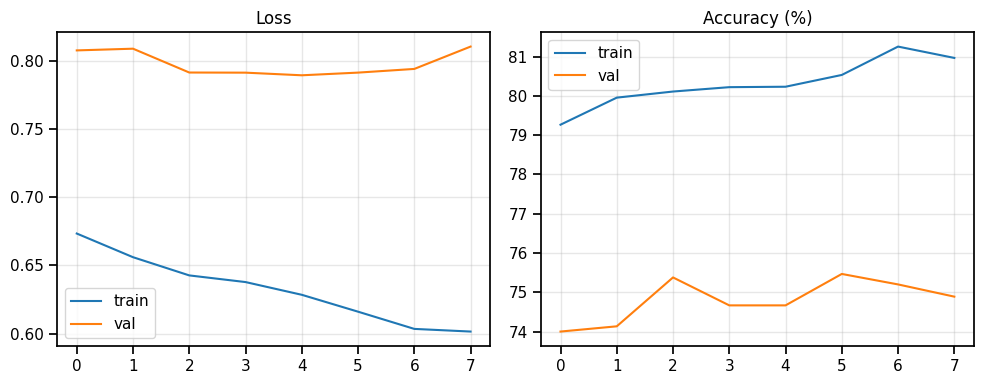

[VAL]  Acc=74.89% | Macro-F1=0.748
[TEST] Acc=78.64% | Macro-F1=0.785


In [32]:
# ---- ГРАФИКИ ----
fig, axs = plt.subplots(1, 2, figsize=(10,4))
axs[0].plot(history["train_loss"], label="train")
axs[0].plot(history["val_loss"],   label="val")
axs[0].set_title("Loss"); axs[0].legend(); axs[0].grid(True, alpha=0.3)

axs[1].plot(np.array(history["train_acc"])*100, label="train")
axs[1].plot(np.array(history["val_acc"])*100,   label="val")
axs[1].set_title("Accuracy (%)"); axs[1].legend(); axs[1].grid(True, alpha=0.3)
plt.tight_layout(); plt.show()

# ---- Итоговые метрики: VAL и TEST (Accuracy, Macro-F1) ----
val_acc, val_f1 = evaluate(model, val_loader)
test_acc, test_f1 = evaluate(model, test_loader)
print(f"[VAL]  Acc={val_acc*100:.2f}% | Macro-F1={val_f1:.3f}")
print(f"[TEST] Acc={test_acc*100:.2f}% | Macro-F1={test_f1:.3f}")

In [33]:
import os, torch

checkpoint_path = "best_model.pt"
assert os.path.exists(checkpoint_path), f"Чекпоинт не найден: {checkpoint_path}"
ckpt = torch.load(checkpoint_path, map_location=device)

# Достаём state_dict из разных вариантов сохранения
if "model_state_dict" in ckpt:
    state = ckpt["model_state_dict"]
elif "state_dict" in ckpt:  # иногда так сохраняют (e.g. Lightning)
    state = ckpt["state_dict"]
else:
    # возможно, сохранён чистый state_dict без обёртки
    state = ckpt

# (необязательно) Проверка метаданных, если сохранял их
if "num_classes" in ckpt:
    assert ckpt["num_classes"] == NUM_CLASSES, \
        f"NUM_CLASSES в ckpt={ckpt['num_classes']} != текущему={NUM_CLASSES}"
if "chosen_cls" in ckpt:
    assert list(ckpt["chosen_cls"]) == list(map(int, chosen_cls)), \
        "Порядок chosen_cls отличается от того, с которым обучалась модель"

# Загружаем веса
model.load_state_dict(state, strict=True)
model = model.to(device).eval()
print(f"✅ Загружен чекпоинт: {checkpoint_path}")


✅ Загружен чекпоинт: best_model.pt


In [34]:
# =============== Дополнительные импорты для метрик ===============
from sklearn.metrics import confusion_matrix, classification_report, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

def compute_ece(probs, labels, n_bins=15):
    """Вычисление Expected Calibration Error"""
    import numpy as np
    
    probs = np.array(probs)
    labels = np.array(labels)
    
    # Получаем максимальные вероятности и предсказания
    max_probs = np.max(probs, axis=1)
    preds = np.argmax(probs, axis=1)
    
    # Создаем бины
    bin_boundaries = np.linspace(0, 1, n_bins + 1)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]
    
    ece = 0.0
    
    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
        # Находим примеры в бине
        in_bin = (max_probs > bin_lower) & (max_probs <= bin_upper)
        prop_in_bin = np.mean(in_bin)
        
        if prop_in_bin > 0:
            # Точность в бине
            accuracy_in_bin = np.mean(preds[in_bin] == labels[in_bin])
            # Средняя уверенность в бине
            avg_confidence_in_bin = np.mean(max_probs[in_bin])
            ece += np.abs(avg_confidence_in_bin - accuracy_in_bin) * prop_in_bin
    
    return ece


# =============== Функции для оценки ===============
def compute_metrics(model, dataloader, device):
    """Вычисление метрик для модели"""
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        for xb, yb in tqdm(dataloader, desc="Оценка", leave=False):
            xb = xb.to(device)
            yb = yb.to(device)
            
            logits = model(xb)
            probs = F.softmax(logits, dim=1)
            preds = logits.argmax(1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(yb.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
    
    # Точность (Top-1 Accuracy)
    accuracy = accuracy_score(all_labels, all_preds)
    
    # F1-macro
    f1 = f1_score(all_labels, all_preds, average='macro')
    
    # ECE (Expected Calibration Error) - наша реализация
    ece = compute_ece(all_probs, all_labels)
    
    return accuracy, f1, ece, all_preds, all_labels, all_probs

def plot_confusion_matrix(labels, preds, class_names):
    """Построение матрицы ошибок"""
    cm = confusion_matrix(labels, preds)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

def plot_reliability_diagram(all_probs, all_labels, num_bins=15):
    """Построение reliability diagram"""
    import numpy as np
    
    all_probs = np.array(all_probs)
    all_labels = np.array(all_labels)
    
    # Получаем максимальные вероятности и предсказания
    max_probs = np.max(all_probs, axis=1)
    preds = np.argmax(all_probs, axis=1)
    
    # Создаем бины
    bin_boundaries = np.linspace(0, 1, num_bins + 1)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]
    
    accuracies = []
    confidences = []
    
    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
        # Находим примеры в бине
        in_bin = (max_probs > bin_lower) & (max_probs <= bin_upper)
        if np.sum(in_bin) > 0:
            # Вычисляем точность в бине
            accuracy_in_bin = np.mean(preds[in_bin] == all_labels[in_bin])
            # Вычисляем среднюю уверенность в бине
            confidence_in_bin = np.mean(max_probs[in_bin])
            
            accuracies.append(accuracy_in_bin)
            confidences.append(confidence_in_bin)
        else:
            accuracies.append(0)
            confidences.append((bin_lower + bin_upper) / 2)
    
    # Вычисляем ECE
    counts = [(max_probs > bin_l) & (max_probs <= bin_u) for bin_l, bin_u in zip(bin_lowers, bin_uppers)]
    props = [np.mean(c) for c in counts]
    ece = np.sum(np.abs(np.array(accuracies) - np.array(confidences)) * props)
    
    # Построение графика
    plt.figure(figsize=(8, 6))
    plt.plot([0, 1], [0, 1], 'k--', label='Идеальная калибровка', alpha=0.5)
    plt.plot(confidences, accuracies, 'o-', label=f'Модель (ECE={ece:.4f})')
    plt.xlabel('Достоверность')
    plt.ylabel('Точность')
    plt.title('Reliability Diagram')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


БЕЙЗЛАЙН МОДЕЛЬ
Загружен чекпоинт с эпохи 5, val_loss=0.7894


Оценка:   0%|          | 0/141 [00:00<?, ?it/s]

Оценка:   0%|          | 0/36 [00:00<?, ?it/s]

Оценка:   0%|          | 0/59 [00:00<?, ?it/s]


Метрики на train:
  Top-1 Accuracy: 82.81%
  F1-macro: 0.8278
  ECE: 0.0571

Метрики на val:
  Top-1 Accuracy: 74.67%
  F1-macro: 0.7453
  ECE: 0.0214

Метрики на test:
  Top-1 Accuracy: 79.28%
  F1-macro: 0.7910
  ECE: 0.0294

Разница train-val (признак переобучения):
  Accuracy: 8.14%
  F1-macro: 0.0825

ВИЗУАЛИЗАЦИЯ БЕЙЗЛАЙНА


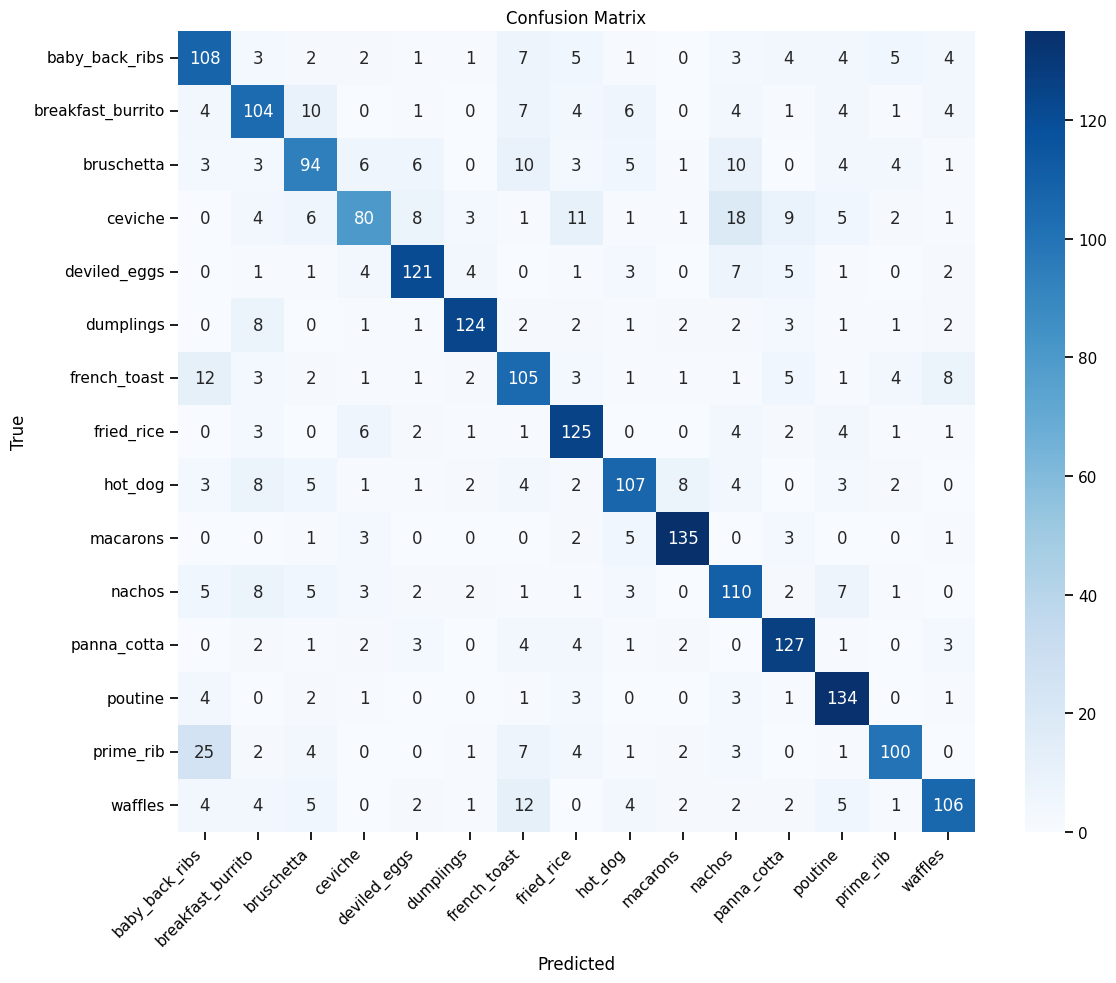

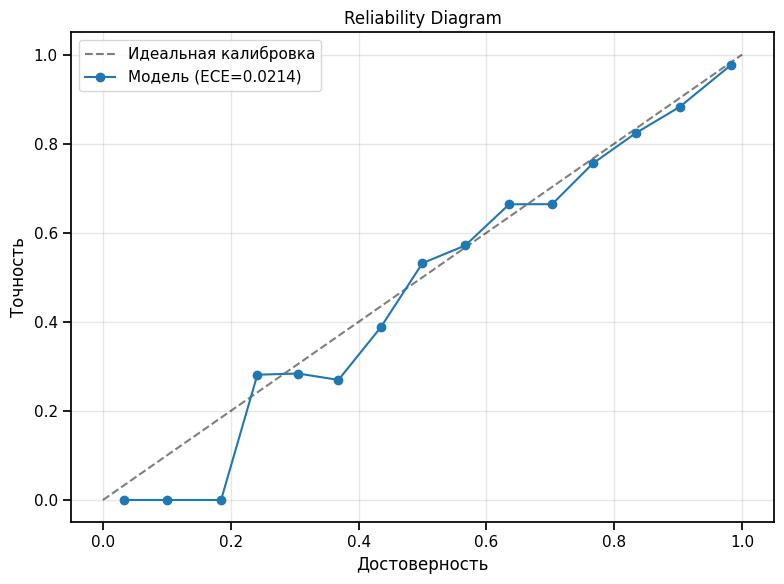

In [35]:
# =============== Оценка бейзлайна ===============
print("\n" + "="*50)
print("БЕЙЗЛАЙН МОДЕЛЬ")
print("="*50)

# Загрузка лучшей модели (если чекпоинт существует)
if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint["model_state_dict"])
    print(f"Загружен чекпоинт с эпохи {checkpoint['epoch']}, val_loss={checkpoint['val_loss']:.4f}")

# Вычисление метрик
train_acc, train_f1, train_ece, _, _, _ = compute_metrics(model, train_loader, device)
val_acc, val_f1, val_ece, val_preds, val_labels, val_probs = compute_metrics(model, val_loader, device)
test_acc, test_f1, test_ece, test_preds, test_labels, test_probs = compute_metrics(model, test_loader, device)

print(f"\nМетрики на train:")
print(f"  Top-1 Accuracy: {train_acc*100:.2f}%")
print(f"  F1-macro: {train_f1:.4f}")
print(f"  ECE: {train_ece:.4f}")

print(f"\nМетрики на val:")
print(f"  Top-1 Accuracy: {val_acc*100:.2f}%")
print(f"  F1-macro: {val_f1:.4f}")
print(f"  ECE: {val_ece:.4f}")

print(f"\nМетрики на test:")
print(f"  Top-1 Accuracy: {test_acc*100:.2f}%")
print(f"  F1-macro: {test_f1:.4f}")
print(f"  ECE: {test_ece:.4f}")

print(f"\nРазница train-val (признак переобучения):")
print(f"  Accuracy: {(train_acc - val_acc)*100:.2f}%")
print(f"  F1-macro: {train_f1 - val_f1:.4f}")

# Построение матрицы ошибок и reliability diagram для val
print("\n" + "="*50)
print("ВИЗУАЛИЗАЦИЯ БЕЙЗЛАЙНА")
print("="*50)

plot_confusion_matrix(val_labels, val_preds, chosen_names)
plot_reliability_diagram(val_probs, val_labels)

# Сохраняем метрики бейзлайна для сравнения
baseline_metrics = {
    'train': {'acc': train_acc, 'f1': train_f1, 'ece': train_ece},
    'val': {'acc': val_acc, 'f1': val_f1, 'ece': val_ece},
    'test': {'acc': test_acc, 'f1': test_f1, 'ece': test_ece},
    'gap': {'acc': train_acc - val_acc, 'f1': train_f1 - val_f1}
}

In [36]:
# =============== Улучшенная модель с Dropout и Weight Decay ===============
print("\n" + "="*50)
print("УЛУЧШЕННАЯ МОДЕЛЬ (Dropout + Weight Decay)")
print("="*50)

set_seed(42)

# 1. Модель с Dropout
class ResNet18WithDropout(nn.Module):
    def __init__(self, num_classes, dropout_rate=0.5, use_pretrained=True):
        super().__init__()
        # Загружаем предобученную ResNet-18
        self.backbone = models.resnet18(
            weights=models.ResNet18_Weights.IMAGENET1K_V1 if use_pretrained else None
        )
        
        # Замораживаем бэкбон
        for param in self.backbone.parameters():
            param.requires_grad = False
        
        # Заменяем последний слой
        in_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Sequential(
            nn.Dropout(p=dropout_rate),
            nn.Linear(in_features, num_classes)
        )
        
    def forward(self, x):
        return self.backbone(x)

# Создаем улучшенную модель
model_improved = ResNet18WithDropout(
    num_classes=NUM_CLASSES,
    dropout_rate=0.3,  # 30% dropout
    use_pretrained=True
).to(device)

# 2. Оптимизатор с Weight Decay
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(
    model_improved.backbone.fc.parameters(),  # Обучаем только голову
    lr=1e-3,
    weight_decay=1e-4  # L2 регуляризация
)

# 3. Обучение улучшенной модели
# на 10 эпохах не заметно улучшение (получилось даже ухудшение, новая модель недообучилась)
EPOCHS = 15
history_improved = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}
best_val_loss_improved = float("inf")
checkpoint_path_improved = "best_model_improved.pt"

for epoch in range(1, EPOCHS + 1):
    # TRAIN
    model_improved.train()
    train_loss = train_acc = 0.0
    n_train = 0
    
    for xb, yb in tqdm(train_loader, desc=f"Epoch {epoch}/{EPOCHS} [train]", leave=False):
        xb = xb.to(device)
        yb = yb.to(device)
        
        optimizer.zero_grad()
        logits = model_improved(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        
        bs = yb.size(0)
        n_train += bs
        train_loss += loss.item() * bs
        train_acc += accuracy_from_logits(logits, yb) * bs
    
    train_loss /= n_train
    train_acc /= n_train
    
    # VAL
    model_improved.eval()
    val_loss = val_acc = 0.0
    n_val = 0
    
    for xb, yb in tqdm(val_loader, desc=f"Epoch {epoch}/{EPOCHS} [val]", leave=False):
        xb = xb.to(device)
        yb = yb.to(device)
        
        with torch.no_grad():
            logits = model_improved(xb)
            loss = criterion(logits, yb)
        
        bs = yb.size(0)
        n_val += bs
        val_loss += loss.item() * bs
        val_acc += accuracy_from_logits(logits, yb) * bs
    
    val_loss /= n_val
    val_acc /= n_val
    
    history_improved["train_loss"].append(train_loss)
    history_improved["val_loss"].append(val_loss)
    history_improved["train_acc"].append(train_acc)
    history_improved["val_acc"].append(val_acc)
    
    print(f"Epoch {epoch:02d}/{EPOCHS} | "
          f"train_loss={train_loss:.4f} val_loss={val_loss:.4f} | "
          f"train_acc={train_acc*100:.1f}% val_acc={val_acc*100:.1f}%")
    
    # Сохранение лучшей модели
    if val_loss < best_val_loss_improved:
        best_val_loss_improved = val_loss
        torch.save({
            "epoch": epoch,
            "model_state_dict": model_improved.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "val_loss": val_loss,
        }, checkpoint_path_improved)
        print(f"💾 Новый лучший чекпоинт сохранён (epoch {epoch})")

print("✅ Обучение улучшенной модели завершено.")


УЛУЧШЕННАЯ МОДЕЛЬ (Dropout + Weight Decay)


Epoch 1/15 [train]:   0%|          | 0/141 [00:00<?, ?it/s]

Epoch 1/15 [val]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 01/15 | train_loss=1.8695 val_loss=1.2558 | train_acc=43.7% val_acc=66.3%
💾 Новый лучший чекпоинт сохранён (epoch 1)


Epoch 2/15 [train]:   0%|          | 0/141 [00:00<?, ?it/s]

Epoch 2/15 [val]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 02/15 | train_loss=1.2442 val_loss=1.0391 | train_acc=63.8% val_acc=69.5%
💾 Новый лучший чекпоинт сохранён (epoch 2)


Epoch 3/15 [train]:   0%|          | 0/141 [00:00<?, ?it/s]

Epoch 3/15 [val]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 03/15 | train_loss=1.1043 val_loss=0.9497 | train_acc=66.9% val_acc=71.6%
💾 Новый лучший чекпоинт сохранён (epoch 3)


Epoch 4/15 [train]:   0%|          | 0/141 [00:00<?, ?it/s]

Epoch 4/15 [val]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 04/15 | train_loss=1.0354 val_loss=0.9122 | train_acc=68.6% val_acc=71.8%
💾 Новый лучший чекпоинт сохранён (epoch 4)


Epoch 5/15 [train]:   0%|          | 0/141 [00:00<?, ?it/s]

Epoch 5/15 [val]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 05/15 | train_loss=1.0099 val_loss=0.8662 | train_acc=68.5% val_acc=73.5%
💾 Новый лучший чекпоинт сохранён (epoch 5)


Epoch 6/15 [train]:   0%|          | 0/141 [00:00<?, ?it/s]

Epoch 6/15 [val]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 06/15 | train_loss=0.9791 val_loss=0.8457 | train_acc=69.3% val_acc=73.9%
💾 Новый лучший чекпоинт сохранён (epoch 6)


Epoch 7/15 [train]:   0%|          | 0/141 [00:00<?, ?it/s]

Epoch 7/15 [val]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 07/15 | train_loss=0.9587 val_loss=0.8501 | train_acc=70.3% val_acc=73.6%


Epoch 8/15 [train]:   0%|          | 0/141 [00:00<?, ?it/s]

Epoch 8/15 [val]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 08/15 | train_loss=0.9628 val_loss=0.8425 | train_acc=70.6% val_acc=73.5%
💾 Новый лучший чекпоинт сохранён (epoch 8)


Epoch 9/15 [train]:   0%|          | 0/141 [00:00<?, ?it/s]

Epoch 9/15 [val]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 09/15 | train_loss=0.9441 val_loss=0.8336 | train_acc=70.9% val_acc=73.5%
💾 Новый лучший чекпоинт сохранён (epoch 9)


Epoch 10/15 [train]:   0%|          | 0/141 [00:00<?, ?it/s]

Epoch 10/15 [val]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 10/15 | train_loss=0.9346 val_loss=0.8227 | train_acc=70.2% val_acc=74.4%
💾 Новый лучший чекпоинт сохранён (epoch 10)


Epoch 11/15 [train]:   0%|          | 0/141 [00:00<?, ?it/s]

Epoch 11/15 [val]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 11/15 | train_loss=0.9332 val_loss=0.8285 | train_acc=70.9% val_acc=74.6%


Epoch 12/15 [train]:   0%|          | 0/141 [00:00<?, ?it/s]

Epoch 12/15 [val]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 12/15 | train_loss=0.9351 val_loss=0.8109 | train_acc=71.1% val_acc=75.0%
💾 Новый лучший чекпоинт сохранён (epoch 12)


Epoch 13/15 [train]:   0%|          | 0/141 [00:00<?, ?it/s]

Epoch 13/15 [val]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 13/15 | train_loss=0.9304 val_loss=0.8140 | train_acc=70.7% val_acc=74.1%


Epoch 14/15 [train]:   0%|          | 0/141 [00:00<?, ?it/s]

Epoch 14/15 [val]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 14/15 | train_loss=0.9368 val_loss=0.8208 | train_acc=70.1% val_acc=73.8%


Epoch 15/15 [train]:   0%|          | 0/141 [00:00<?, ?it/s]

Epoch 15/15 [val]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 15/15 | train_loss=0.9304 val_loss=0.8352 | train_acc=70.7% val_acc=73.3%
✅ Обучение улучшенной модели завершено.



ОЦЕНКА УЛУЧШЕННОЙ МОДЕЛИ


Оценка:   0%|          | 0/141 [00:00<?, ?it/s]

Оценка:   0%|          | 0/36 [00:00<?, ?it/s]

Оценка:   0%|          | 0/59 [00:00<?, ?it/s]


Метрики улучшенной модели на train:
  Top-1 Accuracy: 79.51%
  F1-macro: 0.7947
  ECE: 0.0776

Метрики улучшенной модели на val:
  Top-1 Accuracy: 74.98%
  F1-macro: 0.7488
  ECE: 0.0451

Метрики улучшенной модели на test:
  Top-1 Accuracy: 78.93%
  F1-macro: 0.7890
  ECE: 0.0596

Разница train-val (признак переобучения):
  Accuracy: 4.53%
  F1-macro: 0.0460


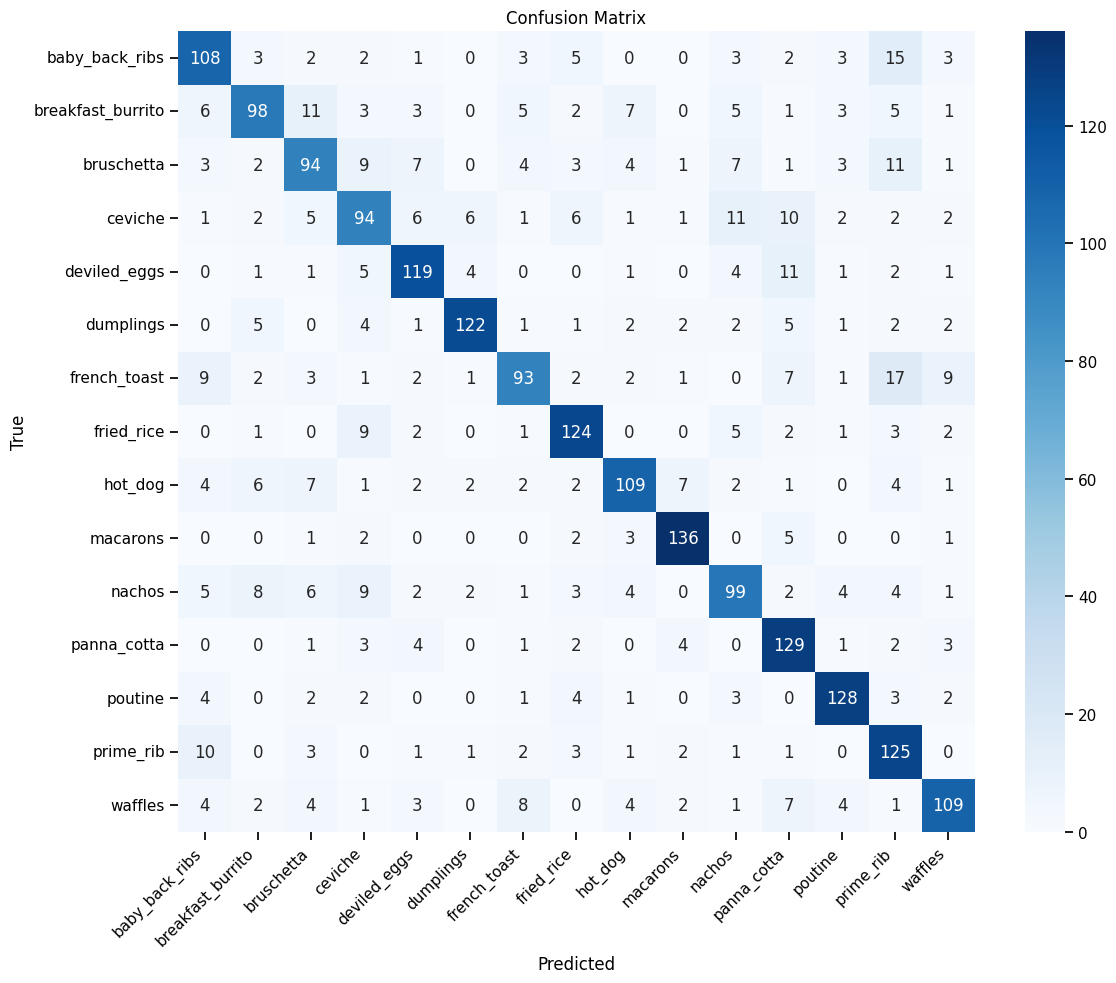

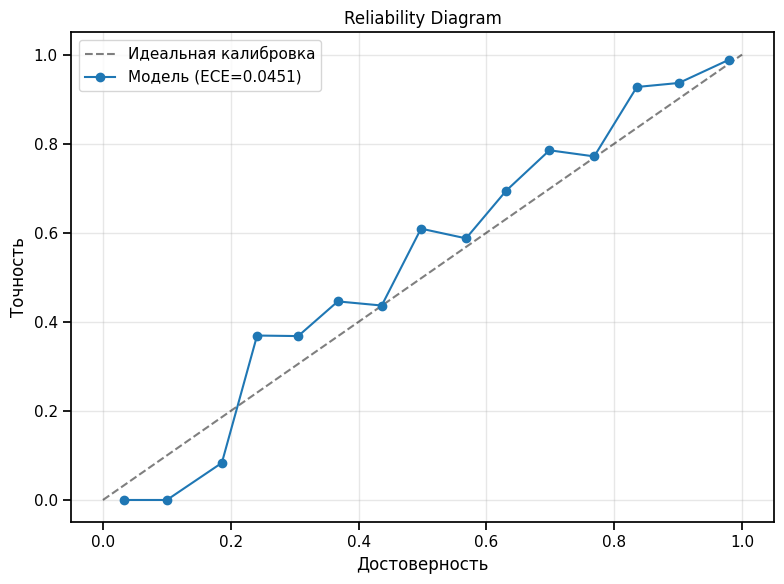

In [37]:
# =============== Оценка улучшенной модели ===============
print("\n" + "="*50)
print("ОЦЕНКА УЛУЧШЕННОЙ МОДЕЛИ")
print("="*50)

# Загрузка лучшей улучшенной модели
if os.path.exists(checkpoint_path_improved):
    checkpoint = torch.load(checkpoint_path_improved)
    model_improved.load_state_dict(checkpoint["model_state_dict"])

# Вычисление метрик
train_acc_imp, train_f1_imp, train_ece_imp, _, _, _ = compute_metrics(model_improved, train_loader, device)
val_acc_imp, val_f1_imp, val_ece_imp, val_preds_imp, val_labels_imp, val_probs_imp = compute_metrics(model_improved, val_loader, device)
test_acc_imp, test_f1_imp, test_ece_imp, test_preds_imp, test_labels_imp, test_probs_imp = compute_metrics(model_improved, test_loader, device)

print(f"\nМетрики улучшенной модели на train:")
print(f"  Top-1 Accuracy: {train_acc_imp*100:.2f}%")
print(f"  F1-macro: {train_f1_imp:.4f}")
print(f"  ECE: {train_ece_imp:.4f}")

print(f"\nМетрики улучшенной модели на val:")
print(f"  Top-1 Accuracy: {val_acc_imp*100:.2f}%")
print(f"  F1-macro: {val_f1_imp:.4f}")
print(f"  ECE: {val_ece_imp:.4f}")

print(f"\nМетрики улучшенной модели на test:")
print(f"  Top-1 Accuracy: {test_acc_imp*100:.2f}%")
print(f"  F1-macro: {test_f1_imp:.4f}")
print(f"  ECE: {test_ece_imp:.4f}")

print(f"\nРазница train-val (признак переобучения):")
print(f"  Accuracy: {(train_acc_imp - val_acc_imp)*100:.2f}%")
print(f"  F1-macro: {train_f1_imp - val_f1_imp:.4f}")

# Построение матрицы ошибок и reliability diagram для улучшенной модели
plot_confusion_matrix(val_labels_imp, val_preds_imp, chosen_names)
plot_reliability_diagram(val_probs_imp, val_labels_imp)

# Сохраняем метрики улучшенной модели
improved_metrics = {
    'train': {'acc': train_acc_imp, 'f1': train_f1_imp, 'ece': train_ece_imp},
    'val': {'acc': val_acc_imp, 'f1': val_f1_imp, 'ece': val_ece_imp},
    'test': {'acc': test_acc_imp, 'f1': test_f1_imp, 'ece': test_ece_imp},
    'gap': {'acc': train_acc_imp - val_acc_imp, 'f1': train_f1_imp - val_f1_imp}
}


СРАВНЕНИЕ МОДЕЛЕЙ

Сравнение метрик на валидационном наборе:
Метрика              Бейзлайн        Улучшенная      Изменение      
-----------------------------------------------------------------
Top-1 Accuracy        73.33%        74.98%        +1.64%
F1-macro             0.7453        0.7488        +0.0035
ECE                  0.0214        0.0451        +0.0237

Сравнение разрыва между train и val (переобучение):
Метрика              Бейзлайн        Улучшенная      Изменение      
-----------------------------------------------------------------
Accuracy gap           8.14%         4.53%        -3.61%
F1-macro gap         0.0825        0.0460        -0.0365


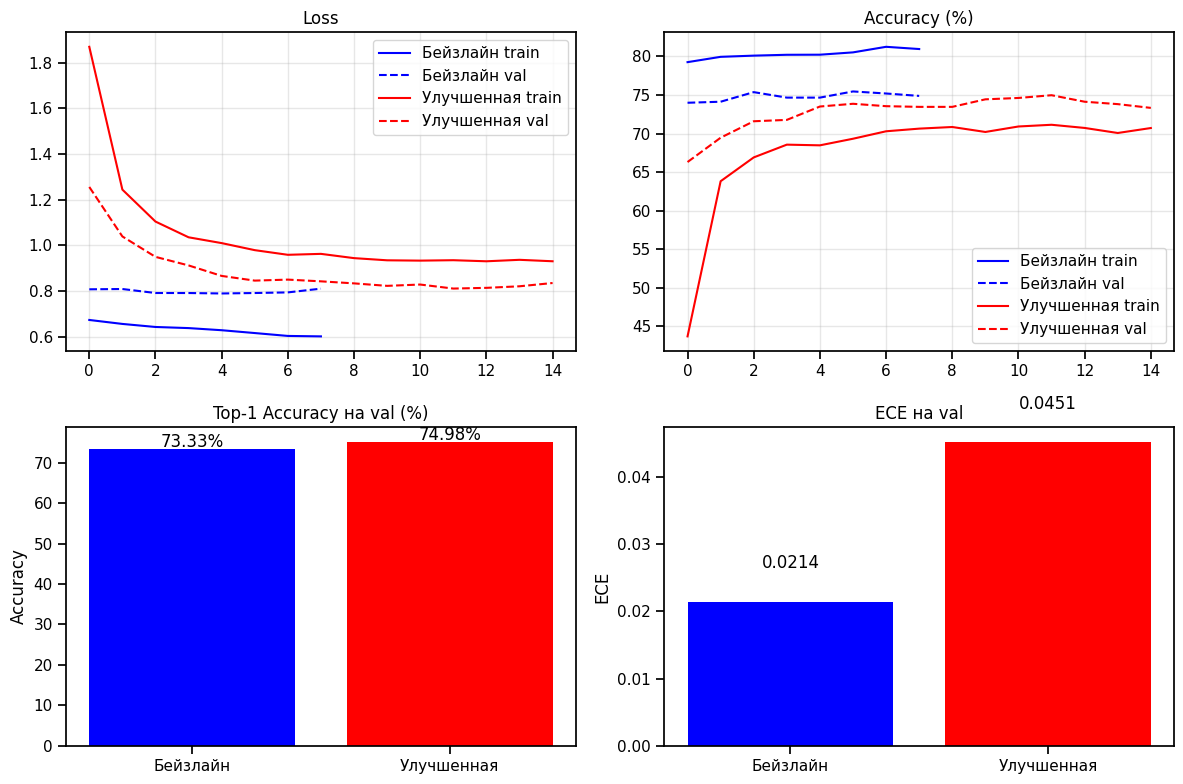

In [38]:
# =============== Сравнение моделей ===============
print("\n" + "="*50)
print("СРАВНЕНИЕ МОДЕЛЕЙ")
print("="*50)

print("\nСравнение метрик на валидационном наборе:")
print(f"{'Метрика':<20} {'Бейзлайн':<15} {'Улучшенная':<15} {'Изменение':<15}")
print("-" * 65)

metrics_to_compare = [
    ("Top-1 Accuracy", val_acc*100, val_acc_imp*100, (val_acc_imp - val_acc)*100),
    ("F1-macro", val_f1, val_f1_imp, val_f1_imp - val_f1),
    ("ECE", val_ece, val_ece_imp, val_ece_imp - val_ece),
]

for name, baseline, improved, change in metrics_to_compare:
    if name == "Top-1 Accuracy":
        print(f"{name:<20} {baseline:>6.2f}%       {improved:>6.2f}%       {change:>+6.2f}%")
    elif name == "ECE":
        print(f"{name:<20} {baseline:>6.4f}        {improved:>6.4f}        {change:>+6.4f}")
    else:
        print(f"{name:<20} {baseline:>6.4f}        {improved:>6.4f}        {change:>+6.4f}")

print("\nСравнение разрыва между train и val (переобучение):")
print(f"{'Метрика':<20} {'Бейзлайн':<15} {'Улучшенная':<15} {'Изменение':<15}")
print("-" * 65)

gap_metrics = [
    ("Accuracy gap", baseline_metrics['gap']['acc']*100, improved_metrics['gap']['acc']*100, 
     (improved_metrics['gap']['acc'] - baseline_metrics['gap']['acc'])*100),
    ("F1-macro gap", baseline_metrics['gap']['f1'], improved_metrics['gap']['f1'], 
     improved_metrics['gap']['f1'] - baseline_metrics['gap']['f1']),
]

for name, baseline, improved, change in gap_metrics:
    if "Accuracy" in name:
        print(f"{name:<20} {baseline:>6.2f}%       {improved:>6.2f}%       {change:>+6.2f}%")
    else:
        print(f"{name:<20} {baseline:>6.4f}        {improved:>6.4f}        {change:>+6.4f}")

# Графики сравнения обучения
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# Loss
axs[0, 0].plot(history["train_loss"], label="Бейзлайн train", color='blue', linestyle='-')
axs[0, 0].plot(history["val_loss"], label="Бейзлайн val", color='blue', linestyle='--')
axs[0, 0].plot(history_improved["train_loss"], label="Улучшенная train", color='red', linestyle='-')
axs[0, 0].plot(history_improved["val_loss"], label="Улучшенная val", color='red', linestyle='--')
axs[0, 0].set_title("Loss")
axs[0, 0].legend()
axs[0, 0].grid(True, alpha=0.3)

# Accuracy
axs[0, 1].plot(np.array(history["train_acc"])*100, label="Бейзлайн train", color='blue', linestyle='-')
axs[0, 1].plot(np.array(history["val_acc"])*100, label="Бейзлайн val", color='blue', linestyle='--')
axs[0, 1].plot(np.array(history_improved["train_acc"])*100, label="Улучшенная train", color='red', linestyle='-')
axs[0, 1].plot(np.array(history_improved["val_acc"])*100, label="Улучшенная val", color='red', linestyle='--')
axs[0, 1].set_title("Accuracy (%)")
axs[0, 1].legend()
axs[0, 1].grid(True, alpha=0.3)

# Сравнение Accuracy на валидации
axs[1, 0].bar(['Бейзлайн', 'Улучшенная'], [val_acc*100, val_acc_imp*100], color=['blue', 'red'])
axs[1, 0].set_title("Top-1 Accuracy на val (%)")
axs[1, 0].set_ylabel("Accuracy")
for i, v in enumerate([val_acc*100, val_acc_imp*100]):
    axs[1, 0].text(i, v + 0.5, f"{v:.2f}%", ha='center')

# Сравнение ECE на валидации
axs[1, 1].bar(['Бейзлайн', 'Улучшенная'], [val_ece, val_ece_imp], color=['blue', 'red'])
axs[1, 1].set_title("ECE на val")
axs[1, 1].set_ylabel("ECE")
for i, v in enumerate([val_ece, val_ece_imp]):
    axs[1, 1].text(i, v + 0.005, f"{v:.4f}", ha='center')

plt.tight_layout()
plt.show()

In [44]:
# =============== ВЫВОДЫ И АНАЛИЗ ===============
print("\n" + "="*50)
print("ВЫВОДЫ И АНАЛИЗ")
print("="*50)

print("\n1. КЛЮЧЕВЫЕ ИЗМЕНЕНИЯ:")
print("   - Добавлен Dropout (30%) в последний слой для регуляризации")
print("   - Использован AdamW с weight_decay=1e-4 вместо Adam")
print("   - Остальные параметры (seed=42, batch_size=64, epochs=15) сохранены")

print("\n2. РЕЗУЛЬТАТЫ:")
if val_acc_imp > val_acc:
    print(f"   ✅ Top-1 Accuracy улучшилась на {(val_acc_imp - val_acc)*100:.2f}%")
else:
    print(f"   ❌ Top-1 Accuracy ухудшилась на {(val_acc - val_acc_imp)*100:.2f}%")

if val_f1_imp > val_f1:
    print(f"   ✅ F1-macro улучшилась на {val_f1_imp - val_f1:.4f}")
else:
    print(f"   ❌ F1-macro ухудшилась на {val_f1 - val_f1_imp:.4f}")

if val_ece_imp < val_ece:
    print(f"   ✅ ECE снизился на {val_ece - val_ece_imp:.4f} (модель стала увереннее)")
else:
    print(f"   ❌ ECE увеличился на {val_ece_imp - val_ece:.4f} (модель стала менее уверенной)")

print("\n3. ПЕРЕОБУЧЕНИЕ:")
gap_improvement_acc = (baseline_metrics['gap']['acc'] - improved_metrics['gap']['acc']) * 100
gap_improvement_f1 = baseline_metrics['gap']['f1'] - improved_metrics['gap']['f1']

if gap_improvement_acc > 0:
    print(f"   ✅ Разрыв accuracy уменьшился на {gap_improvement_acc:.2f}%")
else:
    print(f"   ❌ Разрыв accuracy увеличился на {-gap_improvement_acc:.2f}%")

print("\n4. РЕКОМЕНДАЦИИ ДЛЯ ДАЛЬНЕЙШЕЙ РАБОТЫ:")
print("   - Попробовать более сильные аугментации (RandAugment, TrivialAugment, ColorJitter)")
print("   - Добавить MixUp / CutMix")
print("   - Добавить Label Smoothing")
print("   - Использовать более глубокую архитектуру (ResNet-50)")
print("   - Попробовать больше поставить больше эпох обучения")
print("   - Экспериментировать с разными значениями dropout и weight decay")



ВЫВОДЫ И АНАЛИЗ

1. КЛЮЧЕВЫЕ ИЗМЕНЕНИЯ:
   - Добавлен Dropout (30%) в последний слой для регуляризации
   - Использован AdamW с weight_decay=1e-4 вместо Adam
   - Остальные параметры (seed=42, batch_size=64, epochs=15) сохранены

2. РЕЗУЛЬТАТЫ:
   ✅ Top-1 Accuracy улучшилась на 1.64%
   ✅ F1-macro улучшилась на 0.0035
   ❌ ECE увеличился на 0.0237 (модель стала менее уверенной)

3. ПЕРЕОБУЧЕНИЕ:
   ✅ Разрыв accuracy уменьшился на 3.61%

4. РЕКОМЕНДАЦИИ ДЛЯ ДАЛЬНЕЙШЕЙ РАБОТЫ:
   - Попробовать более сильные аугментации (RandAugment, TrivialAugment, ColorJitter)
   - Добавить MixUp / CutMix
   - Добавить Label Smoothing
   - Использовать более глубокую архитектуру (ResNet-50)
   - Попробовать больше поставить больше эпох обучения
   - Экспериментировать с разными значениями dropout и weight decay
